In [1]:
from time import sleep
import json
import requests
import pandas as pd
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from itertools import chain
import socks
import socket

In [25]:
socks.set_default_proxy(socks.SOCKS5, "localhost", 9150)
socket.socket = socks.socksocket

In [2]:
class Parsing():
    """Парсер товаров интернет-магазина Ситилинк https://www.citilink.ru"""
    def __init__(self, url=None):
        """Задаем ссылку на конкретную группу товара, вида - https://www.citilink.ru/catalog/audio_and_digits/tv/"""
        self.page_count_ = None # Атрибут обнаруженного количества страниц на группу товара
        self.urls_ = None # Список полученных прямых ссылок на карточки товаров
        self.iter_pages_ = None # Количество пройденных страниц парсером в момент поиска прямых ссылок на товары
        self.iter_urls_ = None  # Количество пройденных ссылок в момент парсинга данных по прямым ссылкам на товары
        self.url = url
        
    def set_url(self, url):
        """Метод установки ссылки"""
        self.url = url
    def set_count_page(self, page_count):
        """Метод установки количества страниц, которое необходимо пройти в группе товара,
        чтобы определить прямые ссылки на карточки товаров,
        если не удалось автоматически определить методом .search_params()"""
        self.page_count = page_count
    def set_id_page(self, id_page='55395790'):
        """Метод установки кода страницы, если не удалось определить методом .search_params()"""
        self.id_page = id_page

    def search_params(self):
        """Поиск параметров - количество страниц и код страницы"""
        try:
            if self.url is not None:
                self.r_master = requests.get('{}'.format(self.url))
                self.soup_master = BeautifulSoup(self.r_master.text)
                try:
                    self.page_count = int(self.soup_master.find('div', {'class': 'page_listing'}).find('li', {'class': 'last'}).get_text())
                except:
                    self.page_count = int(self.soup_master.find('div', {'class': 'page_listing'}).find('li', {'class': 'next'}).get_text())
                self.id_page = self.soup_master.find('div', {'class': 'filter_radio filter_controls section2_controls'}).get('data-default')
                self.page_count_ = self.page_count
            else:
                print('Set url')
        except:
            print('Not found. Enter the count of pages and the page code manually')
            
    def search_urls(self, pause=0.3):
        """Метод поиска прямых ссылок на карточки товара, по умолчанию пауза 0.3 сек"""
        self.search_url = '{}?available=1&status={}&p='.format(self.url, self.id_page)
        self.urls = []
        n = 0
        for i in range(1, self.page_count + 1):
            sleep(pause)
            self.r_urls = requests.get('{}{}'.format(self.search_url, i))
            if self.r_urls.status_code != 200:
                print(self.r_urls)
                break
            self.soup_urls = BeautifulSoup(self.r_urls.text)
            self.l = [i.get('href') for i in self.soup_urls.findAll('a', {'class': 'link_gtm-js link_pageevents-js ddl_product_link'})]
            self.urls.append(self.l)
            n += 1
        self.urls = list(chain(*self.urls))  
        self.iter_pages_ = n
        self.urls_ = self.urls
        
    def search_data(self, pause=0.3, max_urls=None):
        """Метод поиска данных на товары по прямым ссылкам на карточки товаров.
        По умолчанию пауза 0.3 сек, 
        по умолчанию парсятся все найденные ссылки, если не задано иное меньшее количество"""
        self.max_urls = len(self.urls) if max_urls is None else max_urls
        self.data = []
        m = 0
        for i in self.urls[:self.max_urls]:
            sleep(pause)
            self.r_data = requests.get('{}'.format(i)) 
            if self.r_data.status_code != 200:
                print(self.r_urls)
                break
            self.soup_data = BeautifulSoup(self.r_data.text)
            self.data_ = self.soup_data.find('script', {'type': 'application/ld+json'}).get_text()
            self.data_= json.loads(self.data_)
            self.data.append(self.data_)
            m += 1
        self.iter_urls_ = m
        
            
    def get_data(self, form='dataframe'):
        """Метод вывода отпарсенных данных. 
        По умолчанию формат выгрузки DataFrame, так же возможен json"""
        if form == 'dataframe':
            return json_normalize(self.data)
        elif form == 'json':
            return self.data

In [3]:
# Создаем экземпляр парсера
parser = Parsing()

In [4]:
# Задаем ссылку на группу товара, например, на радар-детекторы. И определяем параметры группы товара
parser.set_url('https://www.citilink.ru/catalog/car_electronics/radar_detectors/')
parser.search_params()

In [5]:
# Определилось 2 страницы
parser.page_count_

2

In [6]:
# Определяем прямые ссылки на карточки товаров
parser.search_urls()

In [7]:
parser.iter_pages_

2

In [8]:
# Ссылки на товары
parser.urls

['https://www.citilink.ru/catalog/car_electronics/radar_detectors/471707/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/1060662/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/1051623/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/481045/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/1025787/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/473947/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/1126683/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/354724/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/973910/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/1067521/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/354725/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/1067548/',
 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/1079188/',
 'htt

In [9]:
# Теперь по полученным ссылкам отпарсим сами товары
parser.search_data()

In [11]:
# Отпарсили 37 ссылок из 37
parser.iter_urls_, len(parser.urls)

(37, 37)

In [12]:
# Выгрузим полученный датасет (в нем есть, например, цены, рейтинг, кол-во отзывов, ссылки на изображение, описание и пр.)
parser.get_data()

,@context,@type,aggregateRating.@type,aggregateRating.ratingValue,aggregateRating.reviewCount,brand,description,image,mpn,name,offers.@type,offers.availability,offers.itemCondition,offers.price,offers.priceCurrency,offers.priceValidUntil,offers.url,review,sku
0,https://schema.org/,Product,AggregateRating,4.5,104,SILVERSTONE F1,"сигнатурный; диапазоны: X, K, Ka, Laser, Автод...",https://items.s1.citilink.ru/471707_v01_b.jpg,MONACO-S,Радар-детектор SILVERSTONE F1 Monaco S,Offer,InStock,NewCondition,6790,RUB,2020-02-06,https://www.citilink.ru/catalog/car_electronic...,"[{'@type': 'Review', 'name': 'Монако S. Первые...",471707
1,https://schema.org/,Product,AggregateRating,4.5,59,SILVERSTONE F1,"сигнатурный; диапазоны: X, K, Ka, Laser, Автод...",https://items.s1.citilink.ru/1060662_v01_b.jpg,SOCHI-Z,Радар-детектор SILVERSTONE F1 SOCHI-Z,Offer,InStock,NewCondition,7990,RUB,2020-02-06,https://www.citilink.ru/catalog/car_electronic...,[],1060662
2,https://schema.org/,Product,AggregateRating,5,868,SHO-ME,"сигнатурный; диапазоны: X, K, Ka, Ku, Ultra-K,...",https://items.s1.citilink.ru/1051623_v01_b.jpg,Т0000002727,Радар-детектор SHO-ME G-700 Signature,Offer,InStock,NewCondition,4320,RUB,2020-02-06,https://www.citilink.ru/catalog/car_electronic...,"[{'@type': 'Review', 'name': 'Первоклассный ра...",1051623
3,https://schema.org/,Product,AggregateRating,4.5,79,SHO-ME,"сигнатурный; диапазоны: X, K, Ka, АВТОДОРИЯ, ...",https://items.s1.citilink.ru/481045_v01_b.jpg,Т0000002652,Радар-детектор SHO-ME G-800 Signature,Offer,InStock,NewCondition,6010,RUB,2020-02-06,https://www.citilink.ru/catalog/car_electronic...,"[{'@type': 'Review', 'name': 'Защита Вашего ко...",481045
4,https://schema.org/,Product,AggregateRating,5,33,SHO-ME,"сигнатурный; диапазоны: X, K, Ka, Laser, СТРЕ...",https://items.s1.citilink.ru/1025787_v01_b.jpg,Т0000002705,Радар-детектор SHO-ME SIGNATURE EXCELLENT,Offer,InStock,NewCondition,4830,RUB,2020-02-06,https://www.citilink.ru/catalog/car_electronic...,"[{'@type': 'Review', 'name': 'Экономлю деньги ...",1025787
5,https://schema.org/,Product,AggregateRating,4.5,81,SHO-ME,"сигнатурный; диапазоны: X, K, Ka, Laser, СТРЕ...",https://items.s1.citilink.ru/473947_v01_b.jpg,Т0000002653,Радар-детектор SHO-ME G-1000 Signature,Offer,InStock,NewCondition,6870,RUB,2020-02-06,https://www.citilink.ru/catalog/car_electronic...,[],473947
6,https://schema.org/,Product,AggregateRating,5,6,SILVERSTONE F1,"диапазоны: X, K,Ka, Ku, Ultra-K, СТРЕЛКА СТ/М,...",https://items.s1.citilink.ru/1126683_v01_b.jpg,MONACO-GS,Радар-детектор SILVERSTONE F1 Monaco GS,Offer,InStock,NewCondition,5180,RUB,2020-02-06,https://www.citilink.ru/catalog/car_electronic...,[],1126683
7,https://schema.org/,Product,AggregateRating,4,30,SILVERSTONE F1,"диапазоны: X, K, Ka, Laser, СТРЕЛКА СТ/М, ROBO...",https://items.s1.citilink.ru/354724_v01_b.jpg,FUJI,Радар-детектор SILVERSTONE F1 FUJI,Offer,InStock,NewCondition,2210,RUB,2020-02-06,https://www.citilink.ru/catalog/car_electronic...,"[{'@type': 'Review', 'name': 'Отличный бюджетн...",354724
8,https://schema.org/,Product,AggregateRating,4.5,43,SHO-ME,"диапазоны: X, K, Ka, Ku, Laser, СТРЕЛКА СТ/М; ...",https://items.s1.citilink.ru/973910_v01_b.jpg,Т0000002309,Радар-детектор SHO-ME 520-STR,Offer,InStock,NewCondition,2330,RUB,2020-02-06,https://www.citilink.ru/catalog/car_electronic...,"[{'@type': 'Review', 'name': 'Покупка для само...",973910
9,https://schema.org/,Product,AggregateRating,4.5,286,ARTWAY,"диапазоны: Сокол, Барьер, Радис, Визир, Арена,...",https://items.s1.citilink.ru/1067521_v01_b.jpg,RD-200,Радар-детектор ARTWAY RD-200,Offer,InStock,NewCondition,2990,RUB,2020-02-06,https://www.citilink.ru/catalog/car_electronic...,[],1067521


In [13]:
# Так же в review есть на некоторые товары оценки обзоров конкретных людей
json_normalize(parser.get_data().review[0])

,@type,author,datePublished,name,reviewRating.@type,reviewRating.bestRating,reviewRating.ratingValue,reviewRating.worstRating
0,Review,Алексей,2018-05-25,Монако S. Первые впечатления за неделю,Rating,5,4,1
1,Review,Сержант415,2018-02-27,Отличный вариант сэкономить на штрафах!,Rating,5,3.5,1


In [14]:
# Выгрузка json
parser.get_data('json')[:1]

[{'@context': 'https://schema.org/',
  '@type': 'Product',
  'sku': '471707',
  'name': 'Радар-детектор SILVERSTONE F1 Monaco S',
  'description': 'сигнатурный; диапазоны: X, K, Ka, Laser, Автодория, Стрелка, Робот, Арена, Кордон, MESTA, Кордон, Крис, Автоураган, Кречет, Vocord, Поток, Арена, Бинар, Беркут, Визир, ЛИСД, Искра, Радис; голосовые сообщения; электронный компас; защита от ложных срабатываний; обнаружение нескольких сигналов; питание: от прикуривателя',
  'image': 'https://items.s1.citilink.ru/471707_v01_b.jpg',
  'mpn': 'MONACO-S',
  'brand': 'SILVERSTONE F1',
  'offers': {'@type': 'Offer',
   'priceCurrency': 'RUB',
   'availability': 'InStock',
   'itemCondition': 'NewCondition',
   'priceValidUntil': '2020-02-06',
   'price': '6790',
   'url': 'https://www.citilink.ru/catalog/car_electronics/radar_detectors/471707/'},
  'review': [{'@type': 'Review',
    'name': 'Монако S. Первые впечатления за неделю',
    'author': 'Алексей',
    'datePublished': '2018-05-25',
    'rev

Отпарсим еще, например, ультрабуки:

In [15]:
# Создаем экземпляр парсера
parser_nb = Parsing()

In [20]:
parser_nb.set_url('https://www.citilink.ru/catalog/mobile/ultrabuki/')
parser_nb.search_params()
parser_nb.page_count_

2

In [21]:
# Найдено две страницы, но на сайте их три, возможно, в парсер попал другой регион, 
# установим принудительно 3 страницы и отпарсим ссылки на товары
parser_nb.set_count_page(3)
parser_nb.search_urls()
len(parser_nb.urls)

56

In [22]:
# Все три страницы пройдены
parser_nb.iter_pages_

3

In [26]:
# Отпарсим сами ультрабуки
parser_nb.search_data()

In [27]:
# Не с первого раза, но после вкл Тора сработало (первый раз парсер смог пройти только первые 40 ссылок)
parser_nb.iter_urls_, len(parser_nb.urls)

(56, 56)

In [28]:
parser_nb.get_data()

,@context,@type,aggregateRating.@type,aggregateRating.ratingValue,aggregateRating.reviewCount,brand,description,image,mpn,name,offers.@type,offers.availability,offers.itemCondition,offers.price,offers.priceCurrency,offers.priceValidUntil,offers.url,review,sku
0,https://schema.org/,Product,NaN,NaN,NaN,HP,экран: 13.3&quot;; cенсорный экран; разрешени...,https://items.s1.citilink.ru/1027837_v01_b.jpg,2VZ37EA,Ультрабук-трансформер HP Spectre x360 13-ae004...,Offer,InStock,NewCondition,93910,RUB,2020-02-06,https://www.citilink.ru/catalog/mobile/noteboo...,[],1027837
1,https://schema.org/,Product,NaN,NaN,NaN,LENOVO,экран: 14&quot;; разрешение экрана: 1920х108...,https://items.s1.citilink.ru/1059826_v01_b.jpg,20KH006DRT,"Ультрабук LENOVO ThinkPad X1 Carbon, 20KH006DR...",Offer,InStock,NewCondition,105250,RUB,2020-02-06,https://www.citilink.ru/catalog/mobile/noteboo...,[],1059826
2,https://schema.org/,Product,NaN,NaN,NaN,LENOVO,экран: 14&quot;; разрешение экрана: 1920х108...,https://items.s1.citilink.ru/1059839_v01_b.jpg,20KH006JRT,"Ультрабук LENOVO ThinkPad X1 Carbon, 20KH006JR...",Offer,InStock,NewCondition,118180,RUB,2020-02-06,https://www.citilink.ru/catalog/mobile/noteboo...,[],1059839
3,https://schema.org/,Product,AggregateRating,5,1,ACER,экран: 14&quot;; cенсорный экран; разрешение ...,https://items.s1.citilink.ru/1069310_v01_b.jpg,NX.GUHER.002,"Ультрабук ACER Swift 7 SF714-51T-M3AH, NX.GUHE...",Offer,OutOfStock,NewCondition,0,RUB,2019-08-06,https://www.citilink.ru/catalog/mobile/noteboo...,[],1069310
4,https://schema.org/,Product,NaN,NaN,NaN,DELL,экран: 15.6&quot;; cенсорный экран; разрешени...,https://items.s1.citilink.ru/1073415_v01_b.jpg,9575-6740,"Ультрабук DELL XPS 15, 9575-6740, серебристый",Offer,InStock,NewCondition,136810,RUB,2020-02-06,https://www.citilink.ru/catalog/mobile/noteboo...,[],1073415
5,https://schema.org/,Product,AggregateRating,3,1,DELL,экран: 15.6&quot;; cенсорный экран; разрешени...,https://items.s1.citilink.ru/1077888_v01_b.jpg,9570-5420,"Ультрабук DELL XPS 15, 9570-5420, серебристый",Offer,InStock,NewCondition,155040,RUB,2020-02-06,https://www.citilink.ru/catalog/mobile/noteboo...,[],1077888
6,https://schema.org/,Product,NaN,NaN,NaN,DELL,экран: 15.6&quot;; cенсорный экран; разрешени...,https://items.s1.citilink.ru/1086625_v01_b.jpg,9575-7042,"Ультрабук-трансформер DELL XPS 15, 9575-7042, ...",Offer,InStock,NewCondition,140850,RUB,2020-02-06,https://www.citilink.ru/catalog/mobile/noteboo...,[],1086625
7,https://schema.org/,Product,NaN,NaN,NaN,HP,экран: 13.3&quot;; cенсорный экран; разрешени...,https://items.s1.citilink.ru/1097317_v01_b.jpg,5MN23EA,Ультрабук-трансформер HP Spectre x360 13-ap000...,Offer,OutOfStock,NewCondition,79990,RUB,2020-01-31,https://www.citilink.ru/catalog/mobile/noteboo...,[],1097317
8,https://schema.org/,Product,NaN,NaN,NaN,HP,экран: 13.3&quot;; cенсорный экран; разрешени...,https://items.s1.citilink.ru/1097319_v01_b.jpg,5MN15EA,Ультрабук-трансформер HP Spectre x360 13-ap000...,Offer,InStock,NewCondition,95390,RUB,2020-02-06,https://www.citilink.ru/catalog/mobile/noteboo...,[],1097319
9,https://schema.org/,Product,NaN,NaN,NaN,DELL,экран: 13.3&quot;; cенсорный экран; разрешени...,https://items.s1.citilink.ru/1100401_v01_b.jpg,9365-2516,"Ультрабук-трансформер DELL XPS 13, 9365-2516, ...",Offer,InStock,NewCondition,158870,RUB,2020-02-06,https://www.citilink.ru/catalog/mobile/noteboo...,[],1100401


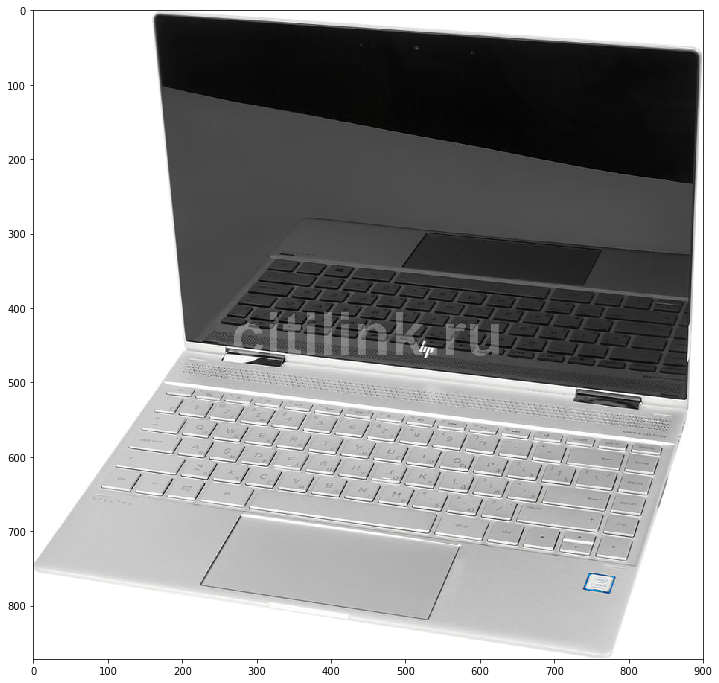

In [32]:
import imageio
import matplotlib.pyplot as plt
from PIL import Image
im = imageio.imread(parser_nb.get_data()['image'][0])
plt.figure(figsize=(12, 12))
plt.imshow(im)
plt.show()
# Ссылки на картинки из датасета рабочие